In [2]:
import os
import sys

module_path = os.path.abspath(os.path.join('..', 'scripts'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import polars as pl
import data_preparation as dp
import ofi_calculator as ofi
import linear_regressors_and_stats as lrs
import visualizer as viz

### Download the parquet files from the Google Drive link to /data directory

Google Drive link:
'https://drive.google.com/drive/folders/1yaZZ-kkn1l64CYVWY2qCMFNdAkA7MFkp?usp=drive_link'

### Computing Multi-Level Order Flow Imbalance (OFI)
This section implements the computation and integration of multi-level Order Flow Imbalance (OFI) metrics, which capture the balance between buying and selling pressure at different price levels in the limit order book.

The code first computes OFI for each of the top 5 price levels for all stocks, then uses Principal Component Analysis (PCA) to integrate these metrics into a single measure. This integration preserves the key information while reducing noise and dimensionality.
The analysis includes:

* Multi-level OFI computation
* PCA integration (first component)
* Weighted PCA integration (linear combination of weighted components accounting for 70% variance)
* Visualization of results
* Statistical analysis of OFI relationships between levels

The code requires LOB data with bid flow, ask flow, and depth information for each price level.

In [14]:
"""
This script processes financial data for a list of symbols over specified time horizons.

The script performs the following steps:
1. Defines a list of stock symbols and time horizons.
2. Initializes dictionaries to store data sources and processed datasets.
3. Loads data for each symbol and stores it in the `datasources` dictionary.
4. For each time horizon, configures the processing parameters and processes the data in time chunks.
5. Concatenates the processed data for all symbols and stores the result in the `datasets` dictionary.

Functions:
- load_symbol_data(symbol): Loads the data for a given stock symbol.
- process_time_chunks(df, config): Processes the data in time chunks based on the given configuration.

Variables:
- symbols (list): List of stock symbols to process.
- horizons (list): List of time horizons for processing data.
- datasources (dict): Dictionary to store raw data for each symbol.
- datasets (dict): Dictionary to store processed datasets for each time horizon.
- config (OFIConfig): Configuration object for processing data.
- dfs (list): List to store processed dataframes for each symbol.
- ml_ofi_df (pl.DataFrame): Concatenated dataframe of processed data for all symbols.
"""
symbols = ['JPM', 'XOM', 'AMGN', 'TSLA', 'AAPL']

horizons = [60]
datasources = {}
datasets = {}

# Get the current working directory
current_dir = os.getcwd()
    
for symbol in symbols:
    df_symbol = dp.load_symbol_data(current_dir, symbol)
    datasources[symbol] = df_symbol

for horizon in horizons:
    config = dp.OFIConfig(num_levels=5, chunk_seconds=horizon)

    dfs = []

    for symbol in symbols:
        df_symbol = datasources[symbol]
        result_df = ofi.process_time_chunks(df_symbol, config)

        dfs.append(result_df)

    ml_ofi_df = pl.concat(dfs).sort('index')
    datasets[f'data_{horizon}_s'] = ml_ofi_df


Loading file from path: /Users/famadeo/Development/GitHub/order-flow-imbalance/notebooks/../data/JPM_20241202-20250104.parquet
Loading file from path: /Users/famadeo/Development/GitHub/order-flow-imbalance/notebooks/../data/XOM_20241202-20250104.parquet
Loading file from path: /Users/famadeo/Development/GitHub/order-flow-imbalance/notebooks/../data/AMGN_20241202-20250104.parquet
Loading file from path: /Users/famadeo/Development/GitHub/order-flow-imbalance/notebooks/../data/TSLA_20241202-20250104.parquet
Loading file from path: /Users/famadeo/Development/GitHub/order-flow-imbalance/notebooks/../data/AAPL_20241202-20250104.parquet


In [15]:
for key in datasets.keys():
    data = datasets[key]
    display(data)

index,symbol,ts_event_start,ts_event_end,log_returns,returns_bps,window_id,ofi_00,ofi_01,ofi_02,ofi_03,ofi_04
u32,str,"datetime[μs, UTC]","datetime[μs, UTC]",f64,f64,i64,f64,f64,f64,f64,f64
0,"""JPM""",2024-12-04 09:00:00 UTC,2024-12-04 09:00:59.999 UTC,0.006528,65.4977,962946,-28.665346,-91.696033,60.153127,0.683558,0.42998
0,"""XOM""",2024-12-04 09:00:00 UTC,2024-12-04 09:00:59.999 UTC,0.024724,250.326513,962946,-15.000115,-34.337252,-85.573936,41.411085,21.650216
0,"""AMGN""",2024-12-04 09:00:00 UTC,2024-12-04 09:00:59.999 UTC,0.00529,53.035514,962946,63.75,5.390625,-70.078125,22.265625,0.234375
0,"""TSLA""",2024-12-04 09:00:00 UTC,2024-12-04 09:00:59.999 UTC,-0.085945,-823.549232,962946,-151.638394,79.423354,7.748724,95.895242,144.468378
0,"""AAPL""",2024-12-04 09:00:00 UTC,2024-12-04 09:00:59.999 UTC,-0.003079,-30.746526,962946,75.765263,29.510476,65.255742,21.689588,15.113078
…,…,…,…,…,…,…,…,…,…,…,…
16976,"""TSLA""",2024-12-31 23:55:00 UTC,2024-12-31 23:55:59.999 UTC,0.000311,3.106748,964271,-5.420076,-3.562389,-14.752224,13.309784,-5.726048
16977,"""TSLA""",2024-12-31 23:56:00 UTC,2024-12-31 23:56:59.999 UTC,-0.000373,-3.726662,964271,12.002671,5.382493,1.583086,-3.871365,2.532938
16978,"""TSLA""",2024-12-31 23:57:00 UTC,2024-12-31 23:57:59.999 UTC,0.000186,1.864026,964271,-9.354145,4.20574,-3.988201,-13.052295,12.327168


In [16]:
import pandas as pd
"""
This script calculates the integrated Order Flow Imbalance (OFI) for each dataset and performs Principal Component Analysis (PCA) on the results.
The script iterates over different time horizons and processes datasets corresponding to each horizon. For each dataset:
1. It drops any NaN values.
2. It iterates over a list of symbols and filters the dataset for each symbol.
3. It calculates the integrated OFI for the filtered dataset and performs PCA.
4. It stores the PCA results in a pandas DataFrame and displays them.
5. It concatenates the processed data for all symbols, sorts it by index, and drops any remaining NaN values.
6. It updates the original dataset with the processed data.
Variables:
- horizons: List of time horizons to process.
- datasets: Dictionary containing datasets for different time horizons.
- symbols: List of symbols to process.
- config: Configuration object containing the number of levels for OFI calculation.
Functions:
- calculate_integrated_ofi: Function to calculate the integrated OFI and perform PCA.
Dependencies:
- pandas as pd
- polars as pl (assumed from context, though not explicitly imported in the given code)
"""

for horizon in horizons:
    dataset = datasets[f'data_{horizon}_s']
    dataset = dataset.drop_nans()

    dfs = []

    for symbol in symbols:
        symbol_df = dataset.filter(pl.col('symbol') == symbol)
        symbol_df, pca_results = ofi.calculate_integrated_ofi(symbol_df, num_levels=config.num_levels)
        dfs.append(symbol_df)

        pd_pca_results = pd.DataFrame(pca_results)
        print(f"Symbol: {symbol} - PCA Results for {horizon} second horizon")
        display(pd_pca_results)
        
    dataset = pl.concat(dfs).sort('index')
    dataset.drop_nans()
    datasets[f'data_{horizon}_s'] = dataset

Symbol: JPM - PCA Results for 60 second horizon


,explained_variance_ratios,cumulative_variance_ratios,first_component_weights
0,0.7171,0.7171,-0.1572
1,0.1612,0.8782,0.0382
2,0.0648,0.9430,0.6846
3,0.0385,0.9815,0.6693
4,0.0185,1.0000,0.2391


Symbol: XOM - PCA Results for 60 second horizon


,explained_variance_ratios,cumulative_variance_ratios,first_component_weights
0,0.8443,0.8443,0.1303
1,0.1256,0.9698,-0.0838
2,0.0169,0.9867,0.5457
3,0.0110,0.9977,0.7546
4,0.0023,1.0000,0.3298


Symbol: AMGN - PCA Results for 60 second horizon


,explained_variance_ratios,cumulative_variance_ratios,first_component_weights
0,0.5183,0.5183,0.0942
1,0.2440,0.7623,0.4840
2,0.1531,0.9154,0.4303
3,0.0699,0.9853,0.2647
4,0.0147,1.0000,0.7083


Symbol: TSLA - PCA Results for 60 second horizon


,explained_variance_ratios,cumulative_variance_ratios,first_component_weights
0,0.3325,0.3325,0.5238
1,0.2377,0.5701,0.1767
2,0.2134,0.7835,0.6355
3,0.1332,0.9167,0.1853
4,0.0833,1.0000,0.5063


Symbol: AAPL - PCA Results for 60 second horizon


,explained_variance_ratios,cumulative_variance_ratios,first_component_weights
0,0.7631,0.7631,-0.5885
1,0.1367,0.8998,0.8054
2,0.0864,0.9862,-0.0387
3,0.0084,0.9946,-0.0077
4,0.0054,1.0000,0.0580


In [17]:
for key in datasets.keys():
    data = datasets[key]
    display(data)

index,symbol,ts_event_start,ts_event_end,log_returns,returns_bps,window_id,ofi_00,ofi_01,ofi_02,ofi_03,ofi_04,integrated_ofi
u32,str,"datetime[μs, UTC]","datetime[μs, UTC]",f64,f64,i64,f64,f64,f64,f64,f64,f64
0,"""JPM""",2024-12-04 09:00:00 UTC,2024-12-04 09:00:59.999 UTC,0.006528,65.4977,962946,-28.665346,-91.696033,60.153127,0.683558,0.42998,NaN
0,"""XOM""",2024-12-04 09:00:00 UTC,2024-12-04 09:00:59.999 UTC,0.024724,250.326513,962946,-15.000115,-34.337252,-85.573936,41.411085,21.650216,NaN
0,"""AMGN""",2024-12-04 09:00:00 UTC,2024-12-04 09:00:59.999 UTC,0.00529,53.035514,962946,63.75,5.390625,-70.078125,22.265625,0.234375,NaN
0,"""TSLA""",2024-12-04 09:00:00 UTC,2024-12-04 09:00:59.999 UTC,-0.085945,-823.549232,962946,-151.638394,79.423354,7.748724,95.895242,144.468378,NaN
0,"""AAPL""",2024-12-04 09:00:00 UTC,2024-12-04 09:00:59.999 UTC,-0.003079,-30.746526,962946,75.765263,29.510476,65.255742,21.689588,15.113078,NaN
…,…,…,…,…,…,…,…,…,…,…,…,…
16976,"""TSLA""",2024-12-31 23:55:00 UTC,2024-12-31 23:55:59.999 UTC,0.000311,3.106748,964271,-5.420076,-3.562389,-14.752224,13.309784,-5.726048,-6.912206
16977,"""TSLA""",2024-12-31 23:56:00 UTC,2024-12-31 23:56:59.999 UTC,-0.000373,-3.726662,964271,12.002671,5.382493,1.583086,-3.871365,2.532938,4.30338
16978,"""TSLA""",2024-12-31 23:57:00 UTC,2024-12-31 23:57:59.999 UTC,0.000186,1.864026,964271,-9.354145,4.20574,-3.988201,-13.052295,12.327168,-1.522525


In [18]:
"""
Processes datasets by performing the following steps:
1. Drops rows with NaN values.
2. Removes outliers from specified columns.

Args:
    datasets (dict): A dictionary where keys are dataset identifiers and values are pandas DataFrames.
    columns_to_check (list): List of column names to check for outliers.
    
Returns:
    None: The function modifies the input dictionary in place.
"""
columns_to_check = ["integrated_ofi", "log_returns", "returns_bps"]

for key in datasets:
    data = datasets[key]
    data = data.drop_nans()
    data = dp.remove_outliers(data, columns_to_check)
    datasets[key] = data


### Contemporaneous Regression of Best Level OFI Against Log Returns

In this section, we perform a contemporaneous regression analysis to investigate the relationship between the Best Level Order Flow Imbalance (OFI) and the log returns for each stock. The Best Level OFI is a measure of the imbalance between buy and sell orders at the best bid and ask prices, which can provide insights into the buying and selling pressure in the market.

The analysis involves the following steps:

1. **Data Preparation**: 
    - Extract the relevant columns (Best Level OFI and log returns) from the dataset for each stock.
    - Ensure the data is clean and free of NaN values.

2. **Regression Analysis**:
    - Perform a linear regression of the Best Level OFI against the log returns for each stock.
    - Calculate the regression coefficients, intercept, and R² score to evaluate the strength and direction of the relationship.

3. **Visualization**:
    - Plot the actual vs. predicted log returns to visually assess the fit of the regression model.
    - Display scatter plots with the regression line to illustrate the relationship between the Best Level OFI and log returns.

4. **Statistical Summary**:
    - Provide a summary of the regression results, including the coefficients, intercept, and R² score for each stock.
    - Discuss the implications of the findings and how the Best Level OFI can be used as a predictor of stock returns.

This analysis helps in understanding the contemporaneous impact of order flow imbalances on stock returns, which can be valuable for trading strategies and market microstructure research.


# Naive linear relationship between Best Level OFI and contemporaneous returns

This section of the code uses a naive linear regression model to analyze the linear relationship between the best level Order Flow Imbalance (OFI) and the contemporaneous returns. The purpose of this analysis is to obtain a preliminary understanding of how the OFI at the best level correlates with the returns observed at the same time.

Key steps in this section include:
1. Data Preparation: The relevant data for OFI and returns are extracted and prepared for regression analysis.
2. Model Initialization: A simple linear regression model is initialized.
3. Model Fitting: The model is fitted to the data, with OFI as the independent variable and returns as the dependent variable.
4. Results Interpretation: The coefficients and statistical significance of the regression model are analyzed to understand the strength and nature of the relationship between OFI and returns.

This initial analysis helps in identifying whether there is a significant linear relationship that warrants further, more sophisticated modeling approaches.


Symbol: AAPL
  Coefficients: [0.36095286]
  Intercept: 0.04006131687426987
  R^2 Score: 0.0130

Symbol: AMGN
  Coefficients: [1.34593958]
  Intercept: 0.10430774641649909
  R^2 Score: 0.0833

Symbol: JPM
  Coefficients: [1.02351686]
  Intercept: -0.009960374978282265
  R^2 Score: 0.0504

Symbol: TSLA
  Coefficients: [1.36407087]
  Intercept: 0.15904047975915717
  R^2 Score: 0.0364

Symbol: XOM
  Coefficients: [0.94573069]
  Intercept: -0.11052516563835396
  R^2 Score: 0.0226



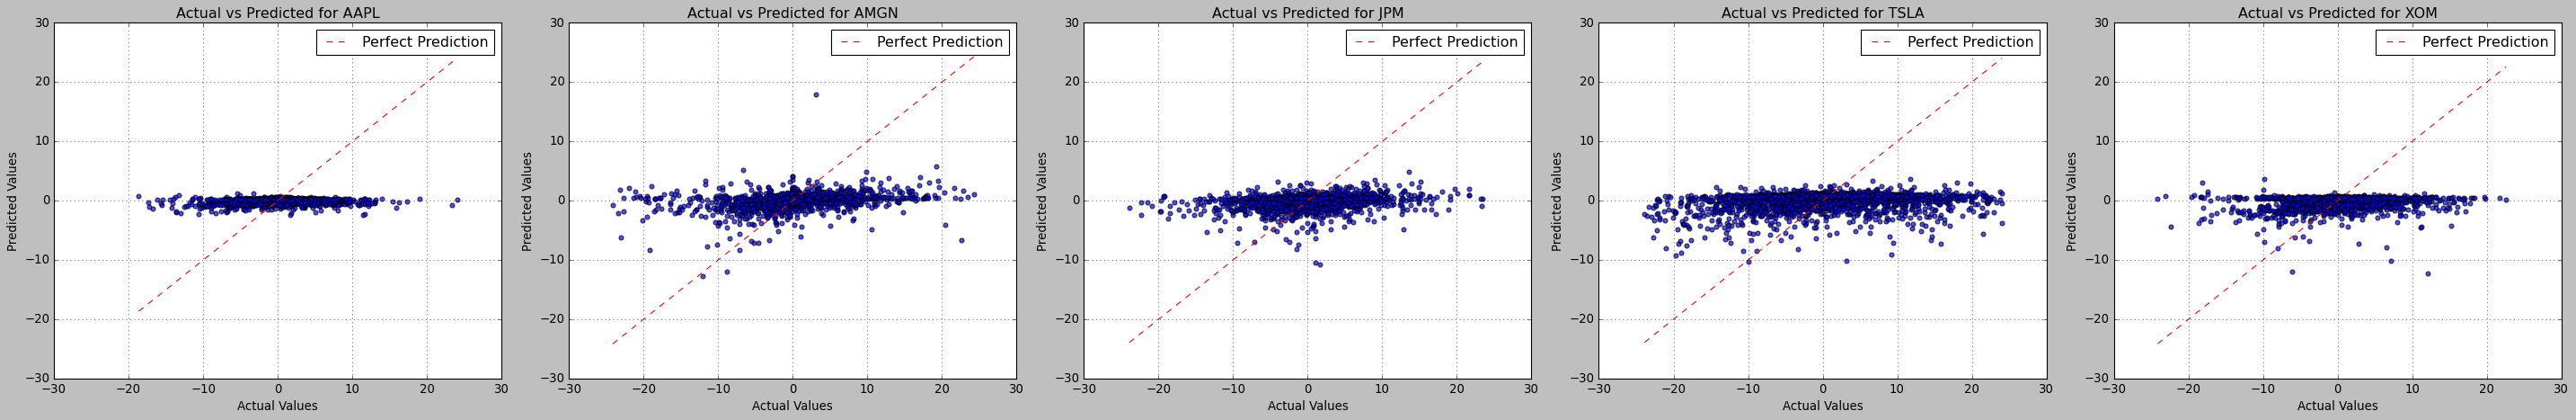

In [19]:
import matplotlib.pyplot as plt

for key in datasets:
    data = datasets[key]
    
    df_pd = data.to_pandas()
    
    # Perform regression
    regression_results = lrs.best_level_regressor(df_pd)

    # Output results and plot
    n_symbols = len(regression_results)
    cols = 5
    rows = (n_symbols + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(36, 6 * rows))
    axes = axes.flatten()

    for i, (symbol, metrics) in enumerate(regression_results.items()):
        print(f"Symbol: {symbol}")
        print(f"  Coefficients: {metrics['coefficients']}")
        print(f"  Intercept: {metrics['intercept']}")
        print(f"  R^2 Score: {metrics['score']:.4f}\n")

        # Plot actual vs predicted
        ax = axes[i]
        ax.scatter(metrics['y_test'], metrics['y_pred'], alpha=0.7)
        ax.plot([min(metrics['y_test']), max(metrics['y_test'])],
                [min(metrics['y_test']), max(metrics['y_test'])], 'r--', label='Perfect Prediction')
        ax.set_title(f'Actual vs Predicted for {symbol}')
        ax.set_xlabel('Actual Values')
        ax.set_ylabel('Predicted Values')
        ax.legend()
        ax.grid(True)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

### Correlation Matrix for Multi-Level OFIs

In this section, we visualize the correlation matrix for the multi-level Order Flow Imbalances (OFIs) for each stock. The correlation matrix helps in understanding the relationships between OFIs at different price levels, providing insights into the dynamics of order flow within the limit order book.

The analysis involves the following steps:

1. **Data Preparation**:
    - Extract the relevant columns (OFIs for each level) from the dataset for each stock.
    - Ensure the data is clean and free of NaN values.

2. **Correlation Calculation**:
    - Compute the correlation matrix for the multi-level OFIs for each stock.
    - The correlation matrix shows the pairwise correlation coefficients between the OFIs at different price levels.

3. **Visualization**:
    - Plot the correlation matrix as a heatmap for each stock.
    - Annotate the heatmap with correlation coefficients to provide a clear understanding of the relationships.

4. **Interpretation**:
    - Analyze the heatmap to identify strong positive or negative correlations between different levels.
    - Discuss the implications of these correlations for understanding the order flow dynamics and potential trading strategies.

This analysis helps in identifying patterns and relationships in the order flow imbalances at different price levels, which can be valuable for market microstructure research and trading strategy development.

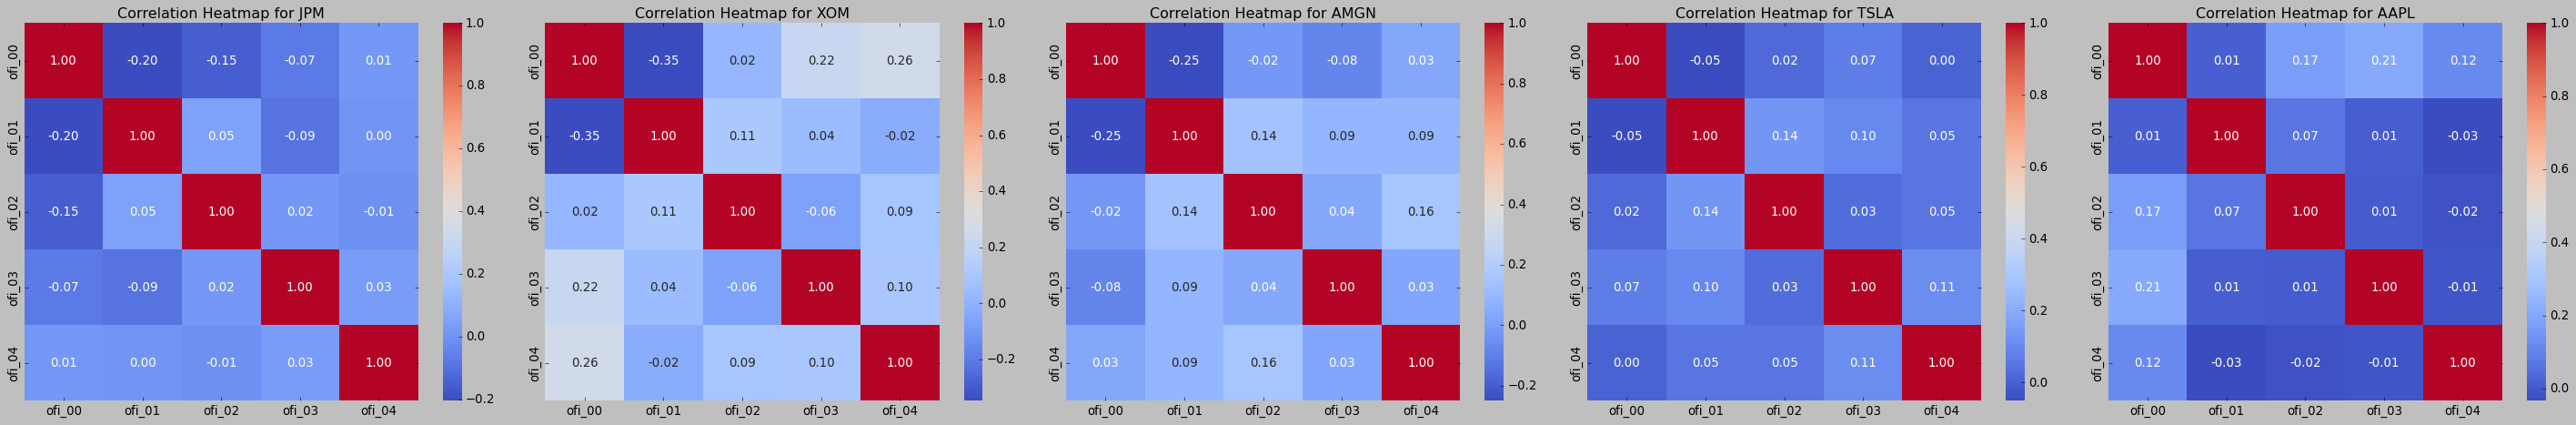

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt


for key in datasets:
    data = datasets[key]
    
    fig, axes = plt.subplots(nrows=1, ncols=len(symbols), figsize=(36, 6))

    # Iterate over each symbol and plot the heatmap
    for i, symbol in enumerate(symbols):
        symbol_df = data.filter(pl.col('symbol') == symbol)
        ofi_cols = [f'ofi_{j:02d}' for j in range(config.num_levels)]
        
        # Calculate the correlation matrix
        correlation_matrix = symbol_df.select(ofi_cols).to_pandas().corr()
        
        # Plot the heatmap
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', ax=axes[i])
        axes[i].set_title(f'Correlation Heatmap for {symbol}')

    plt.tight_layout()
    plt.show()


### Statistical Properties of Each Stock's Integrated OFI

This section provides a detailed statistical analysis of the Integrated Order Flow Imbalance (OFI) for each stock. The analysis includes:

* Mean and standard deviation to understand the central tendency and dispersion.
* Skewness to measure the asymmetry of the distribution.
* Kurtosis to assess the "tailedness" of the distribution.

The empirical probability distributions are visualized using histograms with kernel density estimates (KDE) to provide a clear understanding of the distribution shape for each stock's Integrated OFI.


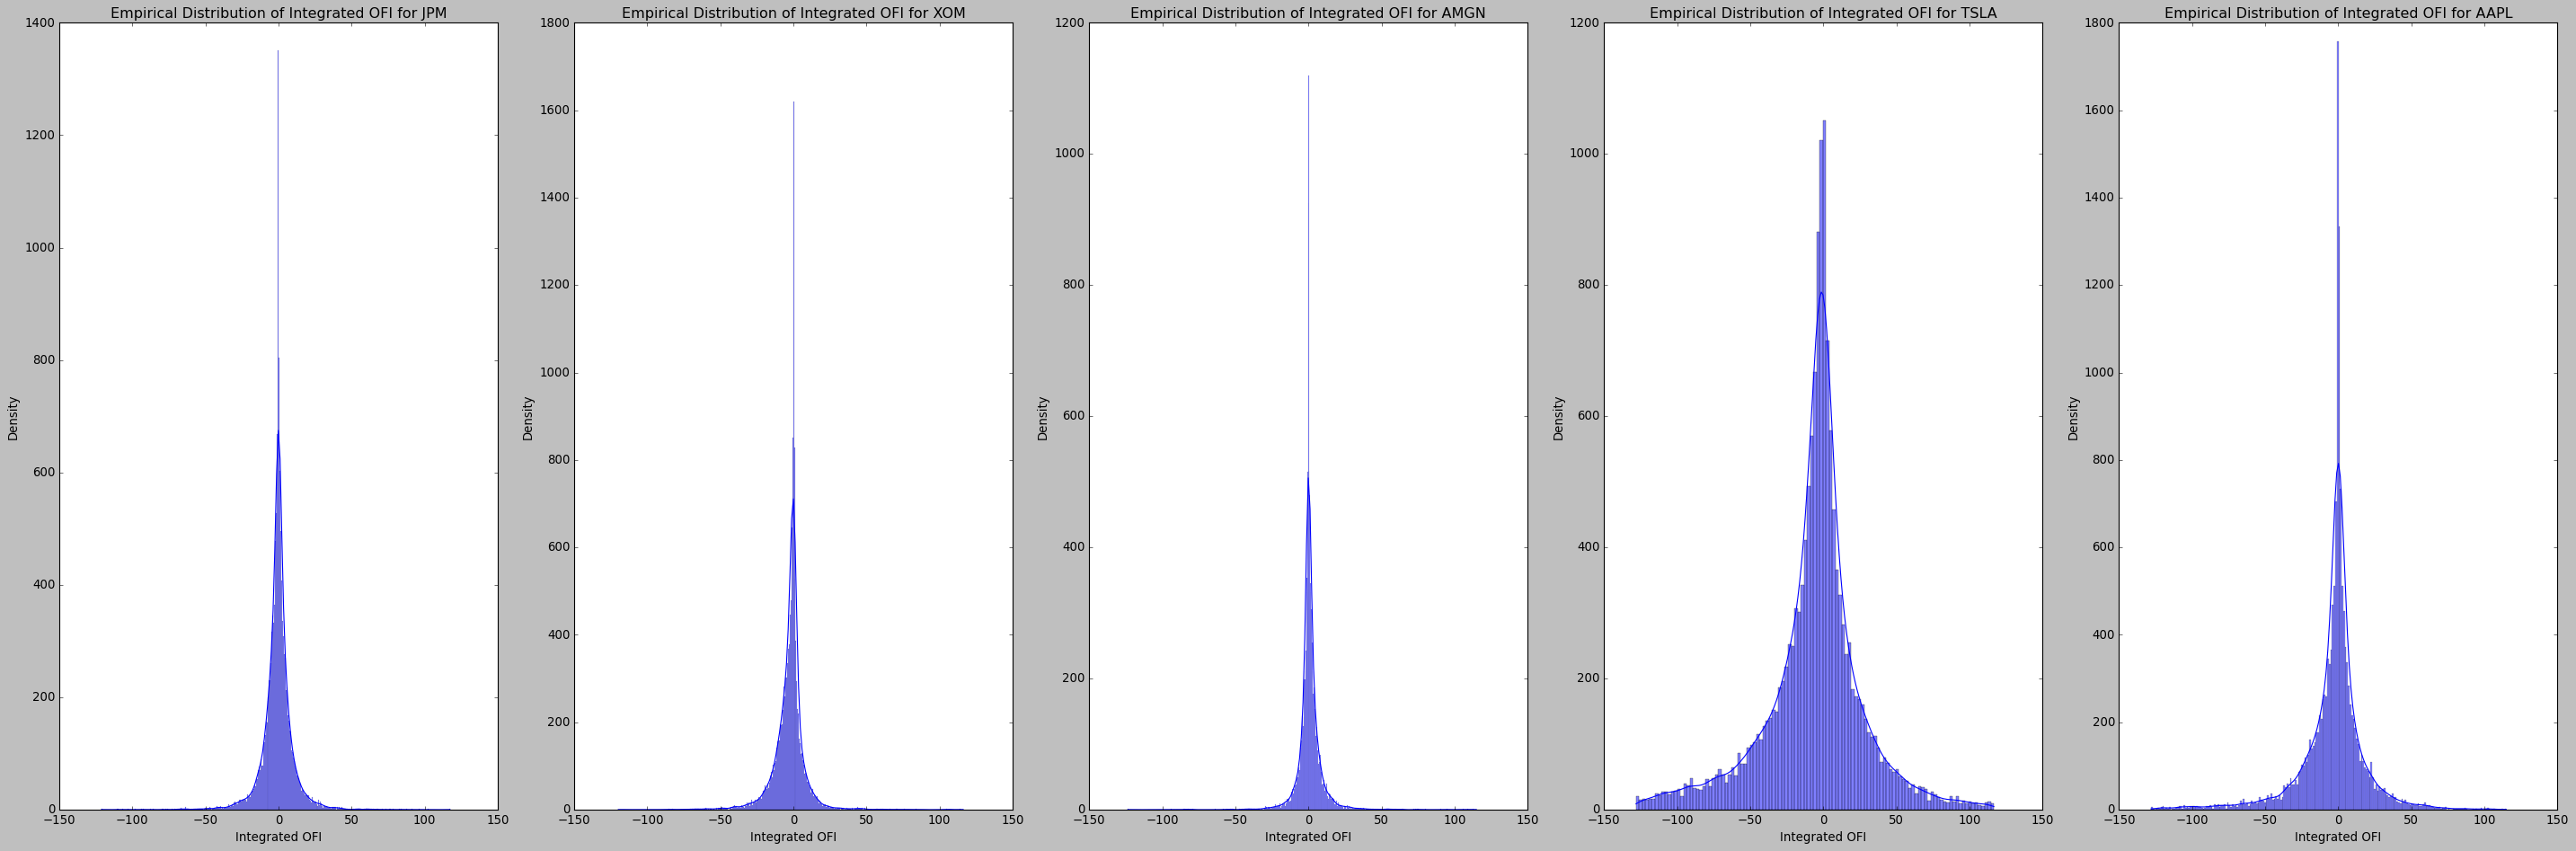

,Symbol,Distribution,Mean,Std,Skew,Kurtosis
0,JPM,Integrated OFI,-0.5379,10.9881,-0.3713,16.0251
1,XOM,Integrated OFI,-2.7006,11.7851,-0.1653,18.9260
2,AMGN,Integrated OFI,0.7975,9.2969,0.7736,36.0137
3,TSLA,Integrated OFI,-6.2672,34.0699,-0.4213,2.1154
4,AAPL,Integrated OFI,-3.5314,23.1729,-1.0906,6.2834


In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import skew, kurtosis
from IPython.display import display

for key in datasets:
    data = datasets[key]

    # Set up the matplotlib figure
    fig, axes = plt.subplots(nrows=1, ncols=len(symbols), figsize=(36, 12))

    # Initialize a list to store the statistics
    stats = []

    # Iterate over each symbol and plot the distributions
    for i, symbol in enumerate(symbols):
        symbol_df = data.filter(pl.col('symbol') == symbol)
        
        # Convert to Pandas DataFrame for Seaborn plotting
        symbol_pd_df = symbol_df.select(['integrated_ofi']).to_pandas()
        
        # Plot the empirical probability distribution for integrated_ofi
        sns.histplot(symbol_pd_df['integrated_ofi'], kde=True, ax=axes[i])
        axes[i].set_title(f'Empirical Distribution of Integrated OFI for {symbol}')
        axes[i].set_xlabel('Integrated OFI')
        axes[i].set_ylabel('Density')
        
        # Calculate statistics for integrated_ofi
        integrated_ofi_stats = {
            'Symbol': symbol,
            'Distribution': 'Integrated OFI',
            'Mean': symbol_pd_df['integrated_ofi'].mean(),
            'Std': symbol_pd_df['integrated_ofi'].std(),
            'Skew': skew(symbol_pd_df['integrated_ofi']),
            'Kurtosis': kurtosis(symbol_pd_df['integrated_ofi'])
        }
        
        # Append the statistics to the list
        stats.append(integrated_ofi_stats)

    plt.tight_layout()
    plt.show()

    # Create a DataFrame from the statistics list
    stats_df = pd.DataFrame(stats)


    # Set display options for better readability
    pd.set_option('display.float_format', '{:.4f}'.format)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)

    # Display the formatted statistics table
    display(stats_df)

### Descriptive Statistics for Each Stock's Returns

In this section, we calculate and analyze the descriptive statistics for each stock's returns. This analysis provides insights into the distribution and characteristics of the returns, which are crucial for understanding the stock's performance and risk profile.

The analysis includes:

* **Mean and Standard Deviation**: To understand the central tendency and dispersion of the returns.
* **Skewness**: To measure the asymmetry of the return distribution.
* **Kurtosis**: To assess the "tailedness" of the return distribution.

We will visualize the empirical probability distributions of the returns using histograms with kernel density estimates (KDE) to provide a clear understanding of the distribution shape for each stock's returns.


Statistics for JPM (bps):
  Mean: 0.0248
  Std: 4.5694
  Skew: -0.0699
  Kurtosis: 3.9609


Statistics for XOM (bps):
  Mean: -0.0859
  Std: 4.7482
  Skew: -0.1209
  Kurtosis: 3.9239


Statistics for AMGN (bps):
  Mean: 0.0859
  Std: 5.5595
  Skew: 0.1235
  Kurtosis: 3.5847


Statistics for TSLA (bps):
  Mean: 0.1722
  Std: 7.6692
  Skew: -0.0274
  Kurtosis: 0.9914


Statistics for AAPL (bps):
  Mean: 0.0259
  Std: 3.5150
  Skew: 0.1778
  Kurtosis: 6.0869




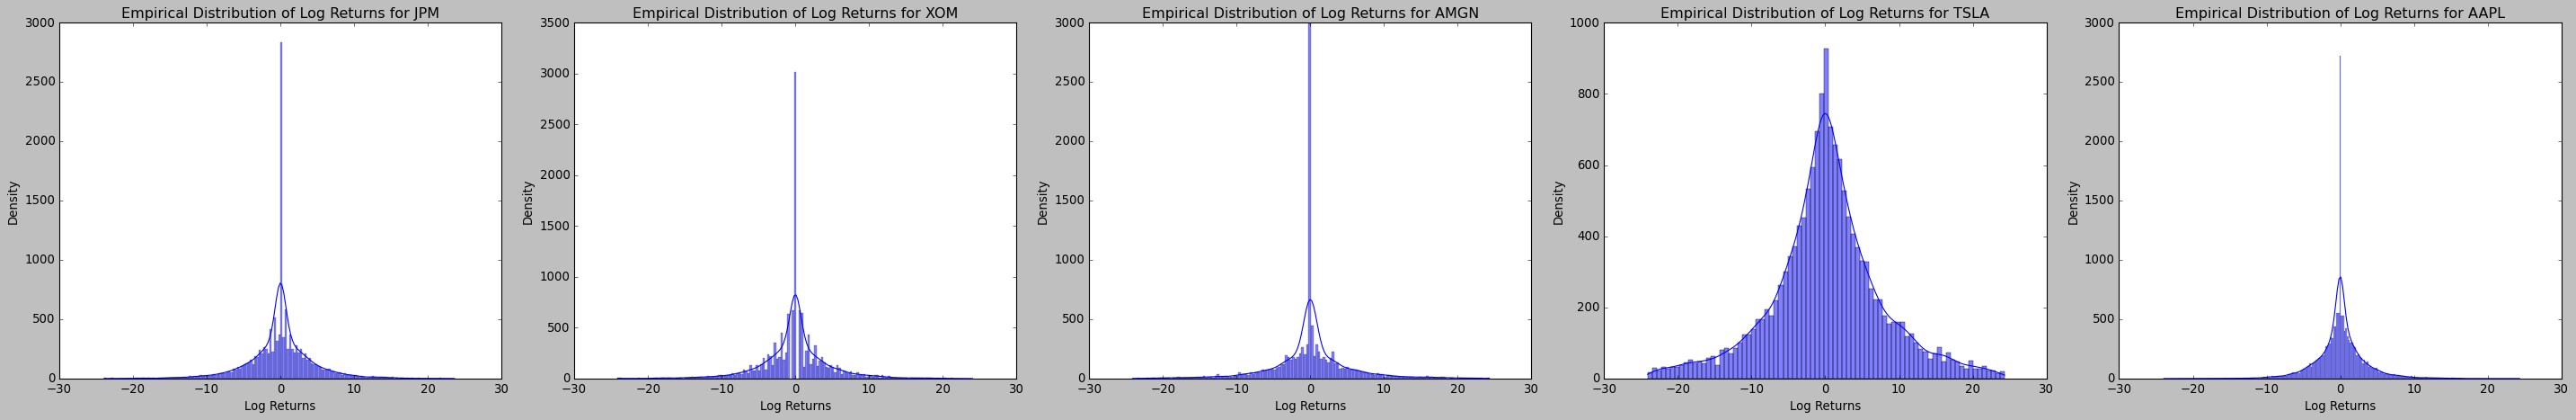

In [22]:
for key in datasets:
    data = datasets[key]

    #plot the log returns for each symbol
    fig, axes = plt.subplots(nrows=1, ncols=len(symbols), figsize=(36, 6))

    for i, symbol in enumerate(symbols):
        symbol_df = data.filter(pl.col('symbol') == symbol)
        
        sns.histplot(symbol_df['returns_bps'], kde=True, ax=axes[i])
        axes[i].set_title(f'Empirical Distribution of Log Returns for {symbol}')
        axes[i].set_xlabel('Log Returns')
        axes[i].set_ylabel('Density')

        # Calculate the statistics for log returns
        returns_bps_stats = {
            'Mean': symbol_df['returns_bps'].mean(),
            'Std': symbol_df['returns_bps'].std(),
            'Skew': skew(symbol_df['returns_bps']),
            'Kurtosis': kurtosis(symbol_df['returns_bps'])
        }
        print(f"Statistics for {symbol} (bps):")
        for stat, value in returns_bps_stats.items():
            print(f"  {stat}: {value:.4f}")
        print('\n')

    plt.tight_layout()
    plt.show()


In [23]:
"""
Filters and stacks datasets based on common IDs.

This function takes a list of datasets and a list of symbols, filters the datasets to include only the common IDs 
present in all datasets, and then stacks them together.

Args:
    datasets (list): A list of datasets to be filtered and stacked. Each dataset is expected to be a DataFrame or 
                     similar data structure.
    symbols (list): A list of symbols to be used for filtering the datasets. Only the common IDs present in all 
                    datasets will be retained.

Returns:
    list: A list of filtered and stacked datasets containing only the common IDs.

Raises:
    ValueError: If the input datasets or symbols are not in the expected format.
"""

datasets = dp.filter_and_stack_common_ids(datasets, symbols)

In [29]:
import logging
from datetime import time
from typing import Dict, Any
import linear_regressors_and_stats as lrs

def analyze_data_windows(df: pl.DataFrame) -> Dict[str, Any]:
    """
    Analyze the data windows to understand sample sizes
    """
    stats = {}
    
    for symbol in df['symbol'].unique():
        symbol_data = df.filter(pl.col('symbol') == symbol)
        window_sizes = []
        
        for window_id in symbol_data['window_id'].unique():
            window_df = df.filter(pl.col('window_id') == window_id)
            window_size = len(window_df.filter(pl.col('symbol') == symbol))
            window_sizes.append(window_size)
            
        stats[symbol] = {
            'min_window_size': min(window_sizes),
            'max_window_size': max(window_sizes),
            'mean_window_size': np.mean(window_sizes),
            'median_window_size': np.median(window_sizes),
            'windows_count': len(window_sizes),
            'windows_with_sufficient_samples': sum(s >= 10 for s in window_sizes)
        }
    
    return stats

def create_rolling_predictions(df: pl.DataFrame, 
                             model: lrs.LassoForecaster,
                             config: lrs.ForecastConfig) -> pl.DataFrame:
    """
    Create rolling window predictions with enhanced error handling and diagnostics
    """
    predictions = []
    symbols = df['symbol'].unique()
    
    # First analyze the data
    data_stats = analyze_data_windows(df)
    logging.info("\nData Window Statistics:")
    for symbol, stats in data_stats.items():
        logging.info(f"\n{symbol}:")
        for key, value in stats.items():
            logging.info(f"  {key}: {value}")
    
    for symbol in symbols:
        logging.info(f"\nProcessing symbol: {symbol}")
        stock_data = df.filter(pl.col('symbol') == symbol)
        
        valid_windows = 0
        skipped_windows = 0
        
        for window_id in stock_data['window_id'].unique():
            try:
                window_df = df.filter(pl.col('window_id') == window_id)
                
                # Get window size
                window_size = len(window_df.filter(pl.col('symbol') == symbol))
                
                if window_size < config.min_samples:
                    skipped_windows += 1
                    continue
                
                model.fit_window(window_df, symbol)
                prediction = model.predict_window(window_df, symbol)
                ts_event_start = window_df.filter(pl.col('symbol') == symbol)['ts_event_start'][-1]
                
                predictions.append({
                    'ts_event_start': ts_event_start,
                    'symbol': symbol,
                    'predicted_return': prediction[0],
                    'window_id': window_id
                })
                
                valid_windows += 1
                
            except Exception as e:
                skipped_windows += 1
                if isinstance(e, ValueError) and "Insufficient samples" in str(e):
                    if skipped_windows % 100 == 0:  # Log only every 100th skip to avoid spam
                        logging.warning(f"Skipped window for {symbol}, window {window_id}: {str(e)}")
                else:
                    logging.error(f"Failed prediction for {symbol}, window {window_id}: {str(e)}")
                continue
        
        logging.info(f"Completed {symbol}: {valid_windows} valid windows, {skipped_windows} skipped")
    
    if not predictions:
        window_stats = analyze_data_windows(df)
        logging.error("No valid predictions generated. Data statistics:")
        logging.error(f"Window statistics: {window_stats}")
        raise ValueError(f"No valid predictions generated. min_samples={config.min_samples} may be too high for this dataset.")
        
    pred_df = pl.DataFrame(predictions)
    
    # Join with careful handling of missing predictions
    result_df = df.join(pred_df, on=['ts_event_start', 'symbol'], how='left')
    
    # Log summary statistics
    total_windows = len(df['window_id'].unique())
    predicted_windows = len(predictions)
    logging.info(f"Total windows: {total_windows}, Predicted windows: {predicted_windows}")
    logging.info(f"Coverage: {predicted_windows/total_windows:.2%}")
    
    return result_df




### Main Processing Loop Description

The Main Processing Loop is a critical component of our experimental framework. It is responsible for orchestrating the execution of experiments based on specified input parameters. In this context, the inputs are `lags` and `prediction_horizon`.

#### Inputs:
- **lags**: This parameter defines the number of previous time steps to consider for making predictions. For example, if `lags = [1, 5]`, the model will use data from 1 and 5 time steps back as input features.
- **prediction_horizon**: This parameter specifies the number of time steps into the future that the model aims to predict. In this case, `prediction_horizon = 5` means the model will predict the value 5 time steps ahead.

#### Main Processing Loop Steps:

1. **Initialization**:
   - Initialize necessary variables and data structures to store results and intermediate computations.
   - Load and preprocess the dataset to ensure it is in the correct format for the experiments.

2. **Experiment Setup**:
   - Iterate over each combination of `lags` and `prediction_horizon`.
   - For each combination, configure the model and experimental parameters accordingly.

3. **Data Preparation**:
   - For each lag value, create input features by shifting the time series data accordingly.
   - Split the dataset into training and testing sets, ensuring that the temporal order is maintained to prevent data leakage.

4. **Model Training**:
   - Train the model using the training set. The model will learn to map the input features (based on the lag values) to the target variable (future value at the prediction horizon).

5. **Model Evaluation**:
   - Evaluate the trained model on the testing set. Calculate performance metrics such as Mean Squared Error (MSE), Mean Absolute Error (MAE), or any other relevant metrics.
   - Store the evaluation results for later analysis.

6. **Result Aggregation**:
   - Aggregate the results from all experiments to identify trends and insights.
   - Compare the performance of different lag values and prediction horizons to determine the optimal configuration.

7. **Reporting**:
   - Generate comprehensive reports and visualizations to summarize the findings.
   - Highlight key observations, such as which lag values and prediction horizons yielded the best performance.

#### Example Pseudocode:
```python


# ...existing code...

lags = [1, 5]
prediction_horizon = 5

results = []

for lag in lags:
    # Data Preparation
    X_train, X_test, y_train, y_test = prepare_data(data, lag, prediction_horizon)
    
    # Model Training
    model = train_model(X_train, y_train)
    
    # Model Evaluation
    performance = evaluate_model(model, X_test, y_test)
    
    # Store Results
    results.append({
        'lag': lag,
        'prediction_horizon': prediction_horizon,
        'performance': performance
    })

# Result Aggregation and Reporting
report_results(results)

# ...existing code...
```

This loop ensures that all combinations of the specified `lags` and `prediction_horizon` are tested, and the results are systematically collected and analyzed to draw meaningful conclusions.

---

This description provides a detailed overview of the Main Processing Loop, explaining each step and its purpose within the experimental framework.

In [ ]:
# Main processing loop
for key in datasets:
    logging.info(f"\nProcessing dataset: {key}")
    data = datasets[key]
    
    # First analyze the data to determine appropriate min_samples
    data_stats = analyze_data_windows(data)
    min_window_size = min(stats['min_window_size'] for stats in data_stats.values())
    median_window_size = np.median([stats['median_window_size'] for stats in data_stats.values()])
    
    logging.info(f"\nDataset {key} statistics:")
    logging.info(f"Minimum window size: {min_window_size}")
    logging.info(f"Median window size: {median_window_size}")
    
    # Adjust min_samples based on data
    suggested_min_samples = max(10, min(100, int(median_window_size * 0.5)))
    
    config = lrs.ForecastConfig(
        estimation_window=30,
        lags=[1, 5],
        prediction_horizon=5,
        lasso_alpha=0.01,
        market_start=time(10, 0),
        market_end=time(15, 30),
        auto_alpha=True,
        max_iter=2000,
        tol=1e-4,
        cv_folds=5,
        min_samples=suggested_min_samples  # Dynamically adjusted
    )
    
    logging.info(f"Using min_samples={config.min_samples} based on data statistics")
    
    try:
        results = lrs.run_forecasting(data, config)
        
        # Create visualizer and generate plots
        vi = viz.ForecastingVisualizer(results)
        output_dir = f"../results/figures"
        os.makedirs(output_dir, exist_ok=True)
        
        figures = vi.plot_all(save_path=output_dir)
        
        # Generate and save summary
        summary = vi.generate_summary_report()
        with open(f"{output_dir}/summary_{key}.txt", 'w') as f:
            f.write(summary)
        print(f"\n=== Summary for dataset: {key} ===")
        print(summary)
        
    except Exception as e:
        logging.error(f"Failed to process dataset {key}: {str(e)}")
        continue

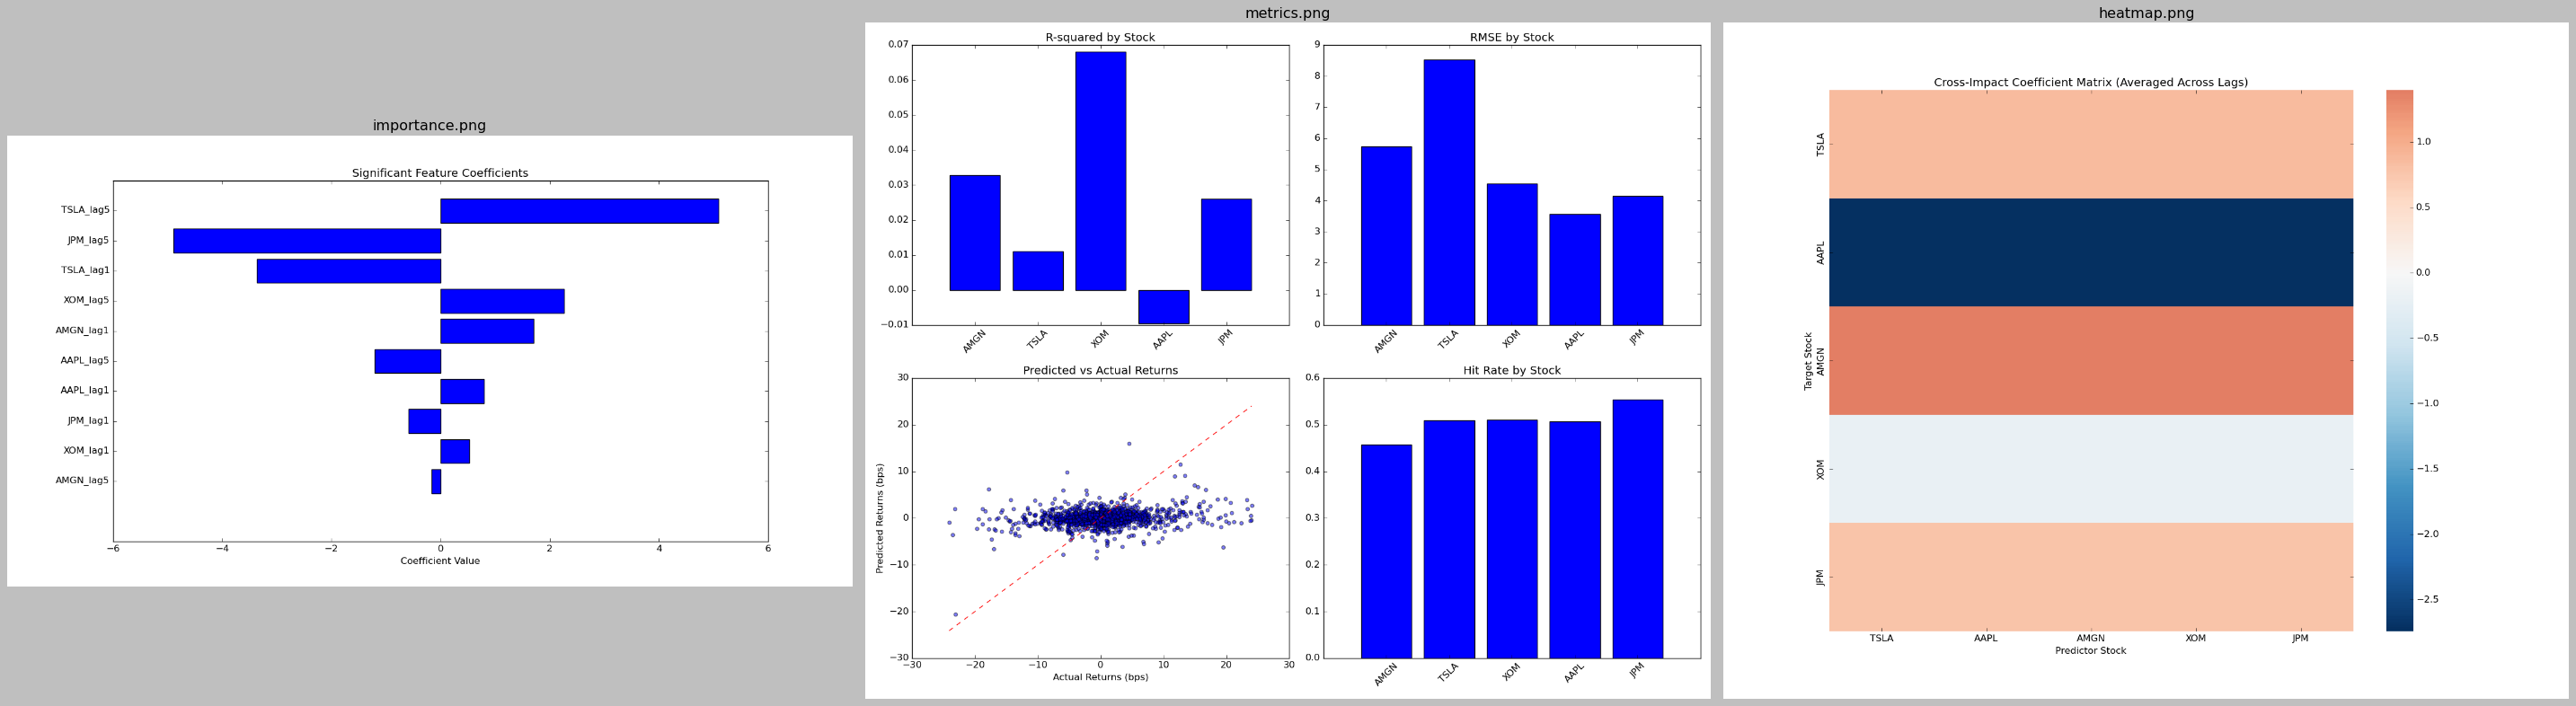

In [28]:
import os
from PIL import Image

import matplotlib.pyplot as plt

# Directory containing the images
image_dir = '../results/figures'

# List all files in the directory
image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]

# Plot each image
fig, axes = plt.subplots(nrows=1, ncols=len(image_files), figsize=(36, 12))

for ax, image_file in zip(axes, image_files):
    image_path = os.path.join(image_dir, image_file)
    image = Image.open(image_path)
    ax.imshow(image)
    ax.set_title(image_file)
    ax.axis('off')

plt.tight_layout()
plt.show()